In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import IPython
import IPython.display
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

# Read CSV

In [7]:
df_raw=pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=['date_time'], index_col='date_time')
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,4918
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,3543
2018-09-30 20:00:00,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
2018-09-30 21:00:00,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159


There are 48,204 total instances, with 9 features:

[0] holiday: string (None or name of holiday).
[1] temp: in degrees kelvin.
[2] rain_1h: in mm for the last hour.
[3] snow_1h: in mm for the last hour.
[4] clouds: percent.
[5] weather_main: short descriptive text.
[6] weather_description: longer descriptive. text
[7] date_time: in Y/m/d H:M:S format. (FIXED)
[8] traffic_volume: # of cars in the last hour.

We will deal with hourly predictions, and the data is expected to be captured at 1 hour intervals:

# Understanding the Data and statistical analysis

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [9]:
df_raw.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


### Check for missing values

In [10]:
df_raw.isna().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
traffic_volume             0
dtype: int64

### Data Overview

In [11]:
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all','traffic_volume']

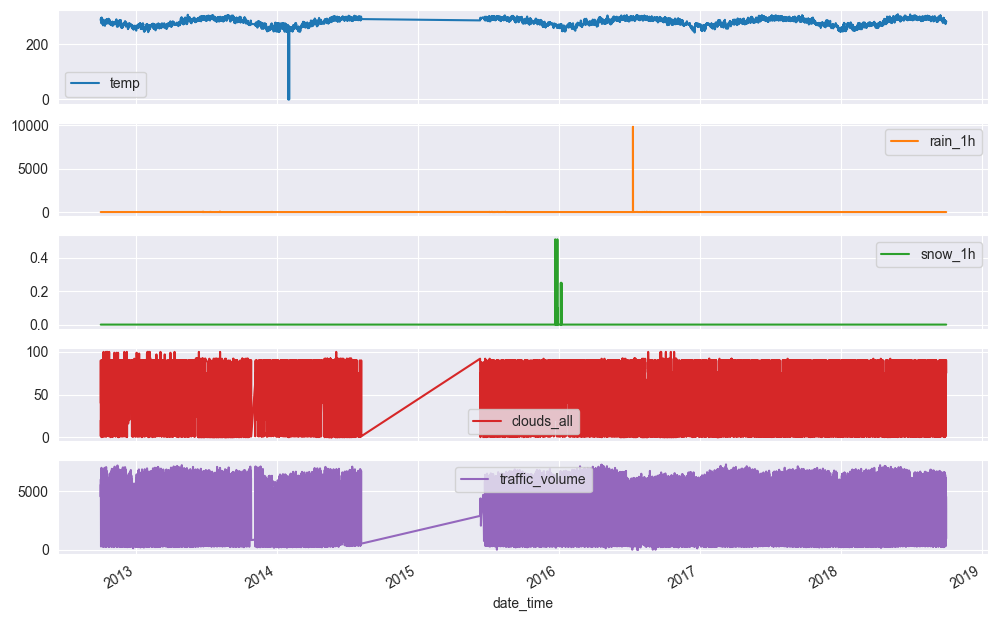

In [12]:
plot_features = df_raw[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2013-10-01 21:00:00,285.52,0.00,0.0,0,2670
2013-10-01 23:00:00,282.93,0.00,0.0,0,1299
2013-10-02 23:00:00,286.63,2.37,0.0,88,899
2013-10-02 23:00:00,286.63,2.37,0.0,88,899
2013-10-02 23:00:00,286.63,2.37,0.0,88,899
...,...,...,...,...,...
2013-11-30 19:00:00,274.27,0.00,0.0,64,3532
2013-11-30 20:00:00,273.16,0.00,0.0,64,2896
2013-11-30 21:00:00,272.51,0.00,0.0,64,2603


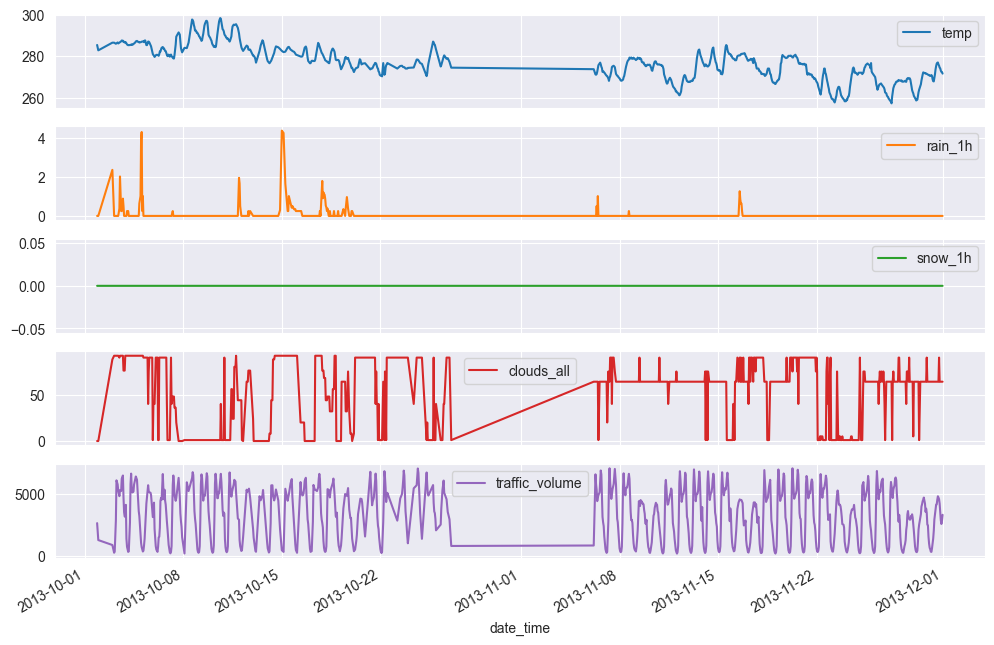

In [13]:
plot_features = df_raw[plot_cols]['2013-10':'2013-11']
display(plot_features)
_ = plot_features.plot(subplots=True, figsize=(12,8))

Data is missing records between 2013–10 and 2013-11, and data is missing records between 2014-08-08 and 2015-06-11

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-08-08 00:00:00,NaN,293.450,0.0,0.0,40,Clouds,scattered clouds,848
2014-08-08 01:00:00,NaN,292.380,0.0,0.0,1,Clear,sky is clear,516
2015-06-11 20:00:00,NaN,287.586,0.0,0.0,92,Rain,light rain,2886


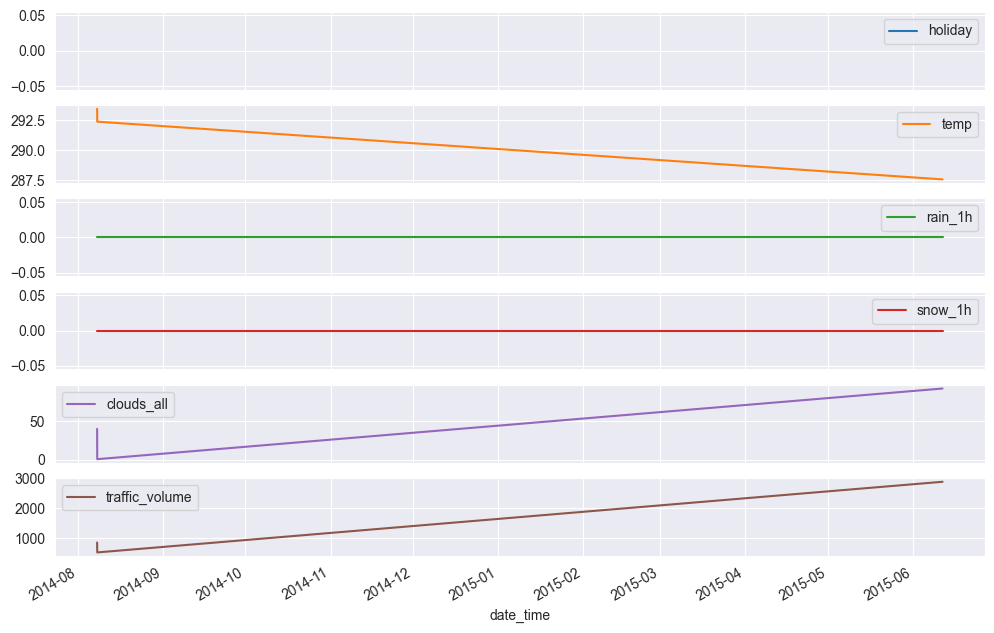

In [14]:
plot_features = df_raw['2014-08-08':'2015-06-11']
display(plot_features)
_ = plot_features.plot(subplots=True, figsize=(12,8))

### Inspect and cleanup

In [16]:
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


In [17]:
df_raw.describe(include='object').transpose()

,count,unique,top,freq
holiday,61,11,Labor Day,7
weather_main,48204,11,Clouds,15164
weather_description,48204,38,sky is clear,11665


## Univariate Analysis

ValueError: cannot reindex on an axis with duplicate labels

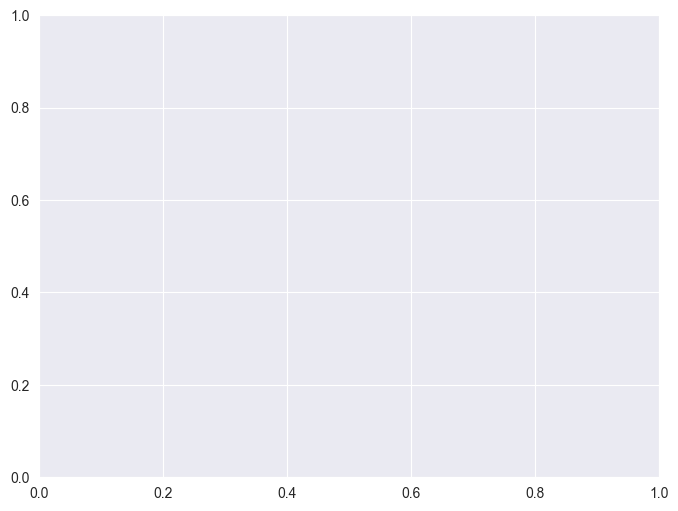

In [20]:
plt.figure(figsize = (8,6))
sns.countplot(y='holiday', data = df_raw)
plt.show()

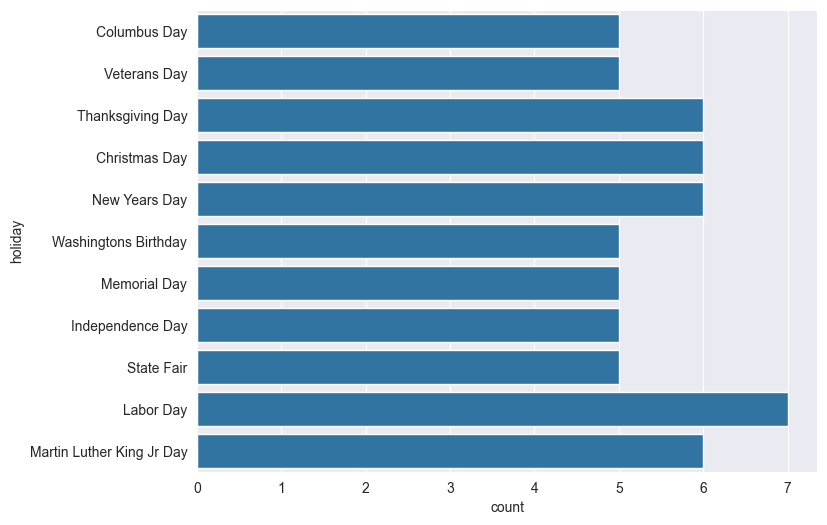

In [29]:
holidays = df_raw[pd.notna(df_raw['holiday'])]
plt.figure(figsize=(8,6))
sns.countplot(y='holiday', data= holidays)
plt.show()

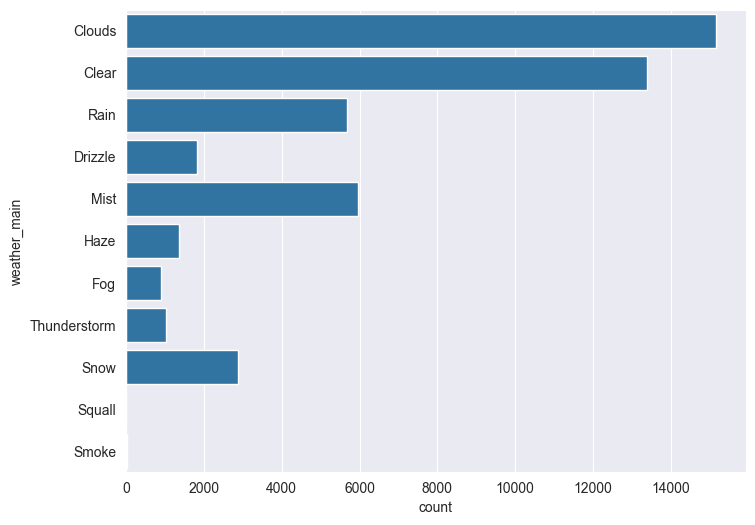

In [30]:
plt.figure(figsize = (8,6))
sns.countplot(y='weather_main', data = df_raw)
plt.show()

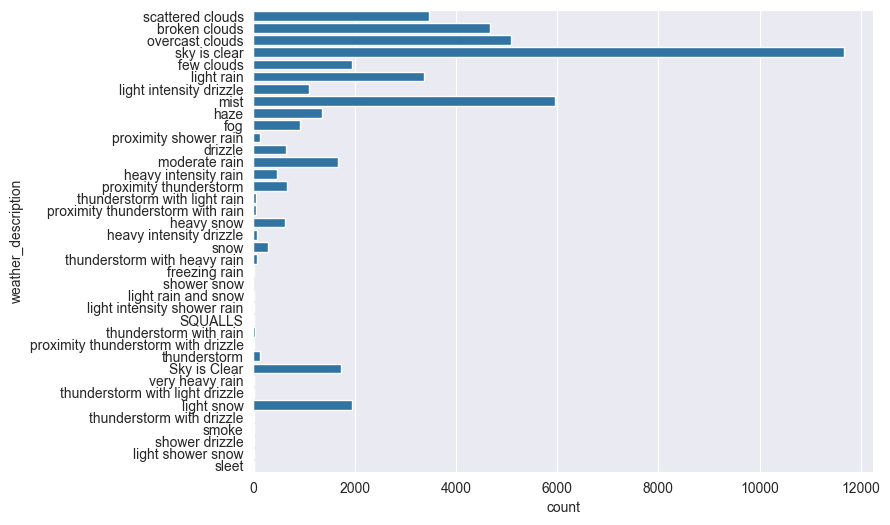

In [31]:
plt.figure(figsize = (8,6))
sns.countplot(y='weather_description', data = df_raw)
plt.show()

### checking outliers

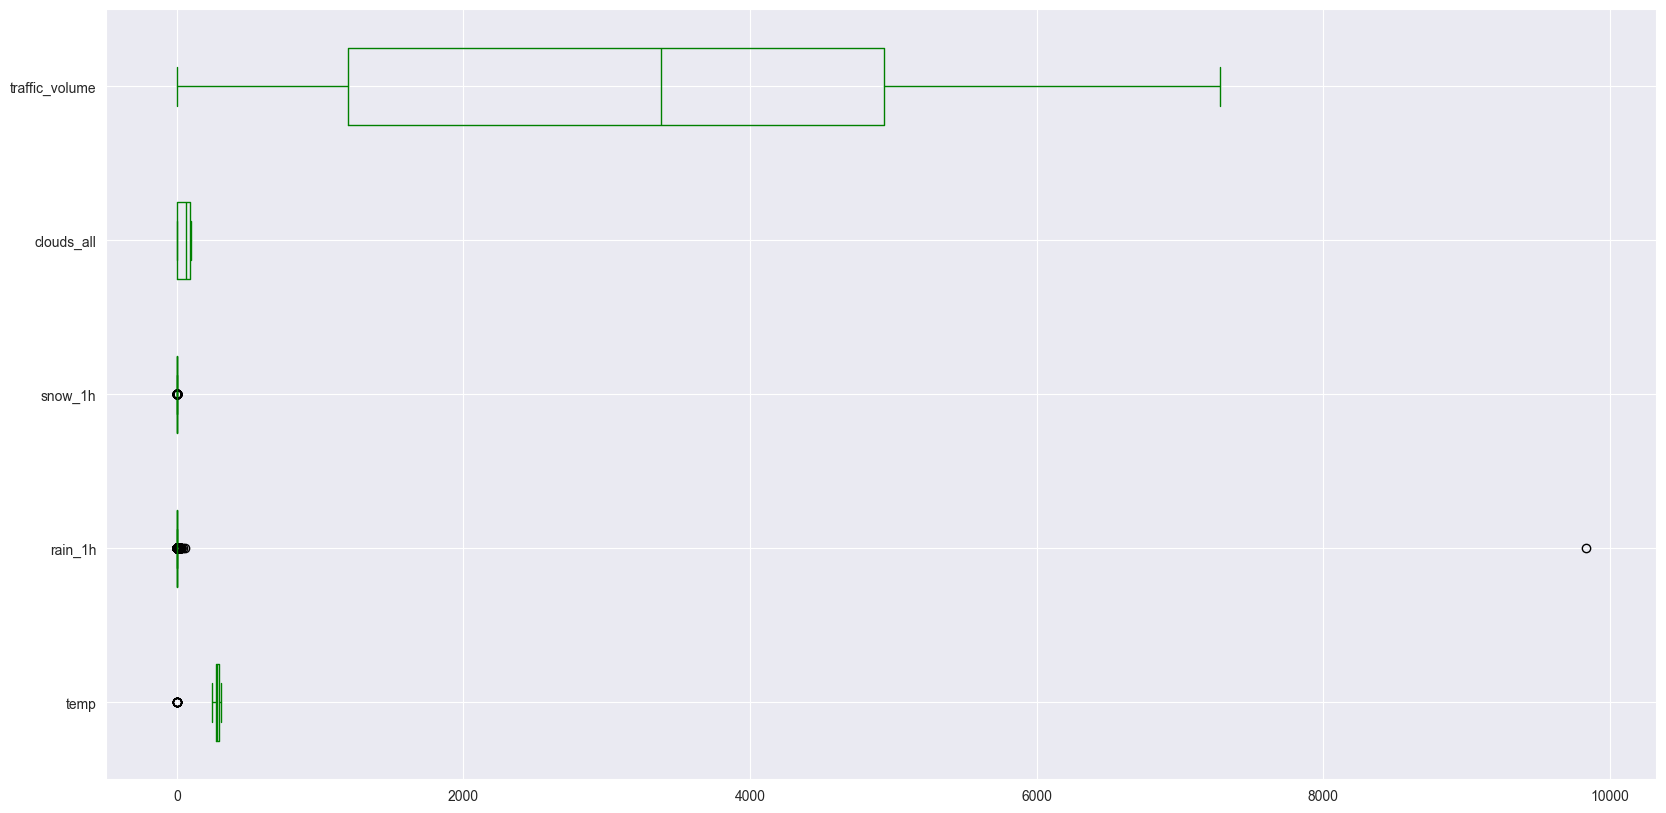

In [32]:
df_raw.plot(kind='box',figsize=(20,10),color='Green',vert=False)
plt.show()

The following observations were made that we need to take care of:

There is no missing data, but that does not mean that there is no inconsistent data.

There are temperature records at absolute zero, clearly inconsistent data.

rain_1h and snow_1h have many zeros and their distribution is not very well defined, since in rare moments they have high records.

Data is missing records between 2013-10 and 2013-11 and data is missing records between 2014-08-08 and 2015-06-11

99.9% of Holiday data is None, and the other data is spread over multiple holidays

## Temperature
Temerature values of 0 seem to be erronoes so we will replace with the mean value of the day. We observe 2 days having erronous values [2014-01-31, 2014-02-02]

In [33]:
df_raw[df_raw.temp == 0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,5150
2014-02-02 03:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,NaN,0.0,0.0,0.0,0,Clear,sky is clear,962


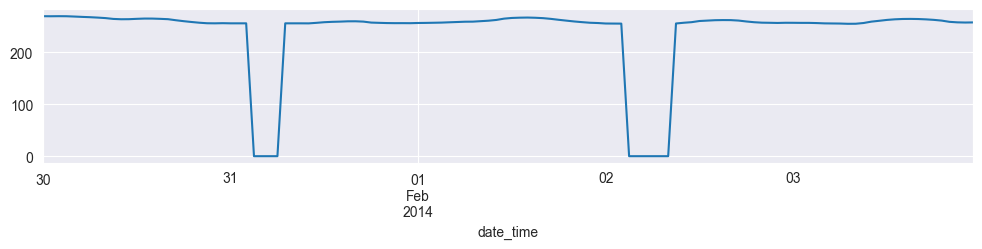

In [34]:
plot_features = df_raw['temp']['2014-01-30':'2014-02-03']
_ = plot_features.plot(figsize=(12,2))

In [36]:
df_raw.loc['2014-01-31']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 00:00:00,NaN,255.93,0.00,0.0,0,Clear,sky is clear,644
2014-01-31 01:00:00,NaN,255.93,0.00,0.0,0,Clear,sky is clear,390
2014-01-31 02:00:00,NaN,255.93,0.00,0.0,0,Clear,sky is clear,313
2014-01-31 03:00:00,NaN,0.00,0.00,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,0.00,0.00,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,0.00,0.00,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,0.00,0.00,0.0,0,Clear,sky is clear,5150
2014-01-31 07:00:00,NaN,255.93,0.00,0.0,0,Clear,sky is clear,5363
2014-01-31 08:00:00,NaN,255.93,0.00,0.0,0,Clear,sky is clear,5269


In [38]:
df_raw.loc['2014-02-02']

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 00:00:00,NaN,255.59,0.0,0.0,0,Clear,sky is clear,1143
2014-02-02 01:00:00,NaN,255.48,0.0,0.0,0,Clear,sky is clear,695
2014-02-02 02:00:00,NaN,255.37,0.0,0.0,0,Clear,sky is clear,539
2014-02-02 03:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,962
2014-02-02 08:00:00,NaN,0.00,0.0,0.0,0,Clear,sky is clear,1670


In [39]:
day_1 = df_raw.index.date == datetime.date(2014, 1, 31)
day_2 = df_raw.index.date == datetime.date(2014, 2, 2)
bad_temps = df_raw['temp'] == 0

df_1 = df_raw.copy()
# Set the zeros to NaN to be excluded from the mean
df_1.loc[bad_temps,'temp'] = np.nan 
df_1[bad_temps]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,5150
2014-02-02 03:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,962


In [40]:
# The means to be used for each day
print(df_1[day_1].temp.mean())
print(df_1[day_2].temp.mean())

257.14
258.4327777777778


In [41]:
df_1[bad_temps & day_1]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,5150


In [42]:
df_1[bad_temps & day_2]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 03:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,962
2014-02-02 08:00:00,NaN,NaN,0.0,0.0,0,Clear,sky is clear,1670


In [43]:
# Set day 1 values
df_1.loc[bad_temps & day_1, 'temp'] = df_1[day_1].temp.mean()
df_1.loc[bad_temps & day_1]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 03:00:00,NaN,257.14,0.0,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,257.14,0.0,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,257.14,0.0,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,257.14,0.0,0.0,0,Clear,sky is clear,5150


In [44]:
# Set day 2 values
df_1.loc[bad_temps & day_2, 'temp'] = df_1[day_2].temp.mean()
df_1.loc[bad_temps & day_2]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-02-02 03:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,962
2014-02-02 08:00:00,NaN,258.432778,0.0,0.0,0,Clear,sky is clear,1670


In [45]:
df_1.loc[day_1 | day_2] # Check both days after assigning the mean

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2014-01-31 00:00:00,NaN,255.930000,0.00,0.0,0,Clear,sky is clear,644
2014-01-31 01:00:00,NaN,255.930000,0.00,0.0,0,Clear,sky is clear,390
2014-01-31 02:00:00,NaN,255.930000,0.00,0.0,0,Clear,sky is clear,313
2014-01-31 03:00:00,NaN,257.140000,0.00,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,NaN,257.140000,0.00,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,NaN,257.140000,0.00,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,NaN,257.140000,0.00,0.0,0,Clear,sky is clear,5150
2014-01-31 07:00:00,NaN,255.930000,0.00,0.0,0,Clear,sky is clear,5363
2014-01-31 08:00:00,NaN,255.930000,0.00,0.0,0,Clear,sky is clear,5269


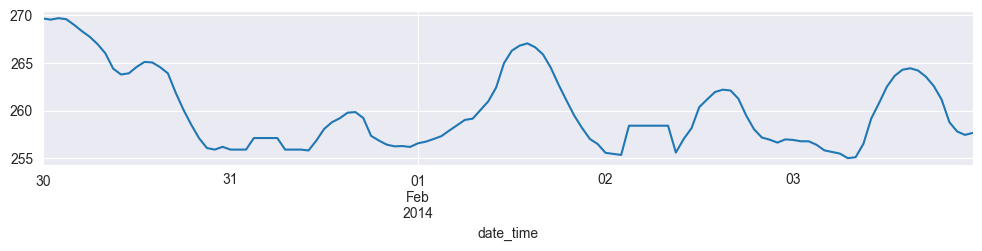

In [46]:
plot_features = df_1['temp']['2014-01-30':'2014-02-03']
_ = plot_features.plot(figsize=(12,2))

## Rain
Rain seems to have only 1 record with extreme value, I'll just set to the general mean value of rain.

In [47]:
df_1[df_1.rain_1h > 100]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2016-07-11 17:00:00,NaN,302.11,9831.3,0.0,75,Rain,very heavy rain,5535


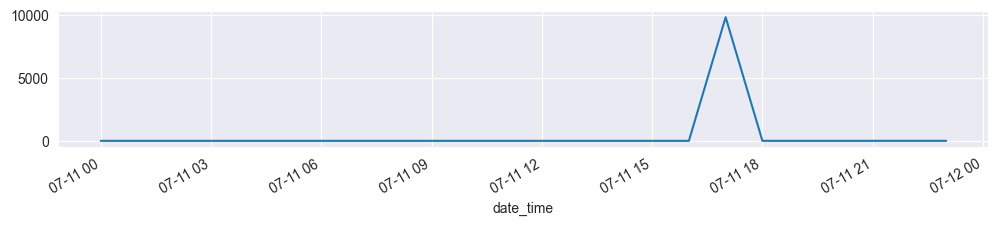

In [48]:
plot_features = df_1.loc['2016-07-11'].rain_1h
_ = plot_features.plot(figsize=(12,2))

In [49]:
df_2 = df_1.copy()
df_2.loc['2016-07-11 17:00:00','rain_1h'] = np.nan
df_2.loc['2016-07-11 17:00:00','rain_1h'] = df_2.rain_1h.mean()

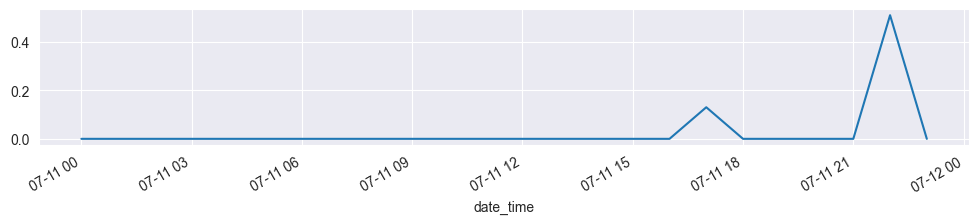

In [51]:
plot_features = df_2.loc['2016-07-11'].rain_1h
_ = plot_features.plot(figsize=(12,2))

## Snow
I cannot determine if the snow has outliers or not, it seems to be an exceptional winter. I'll keep as is.

In [52]:
df_2[(df_2.snow_1h > .2)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-12-23 12:00:00,NaN,274.33,0.98,0.51,90,Rain,moderate rain,5167
2015-12-23 12:00:00,NaN,274.33,0.98,0.51,90,Snow,snow,5167
2015-12-23 12:00:00,NaN,274.33,0.98,0.51,90,Mist,mist,5167
2015-12-23 12:00:00,NaN,274.33,0.98,0.51,90,Fog,fog,5167
2015-12-23 14:00:00,NaN,273.74,0.00,0.32,90,Snow,light snow,5182
2015-12-23 14:00:00,NaN,273.74,0.00,0.32,90,Mist,mist,5182
2015-12-23 14:00:00,NaN,273.74,0.00,0.32,90,Rain,moderate rain,5182
2015-12-23 16:00:00,NaN,273.86,0.00,0.32,90,Snow,light snow,5222
2015-12-23 16:00:00,NaN,273.86,0.00,0.32,90,Mist,mist,5222


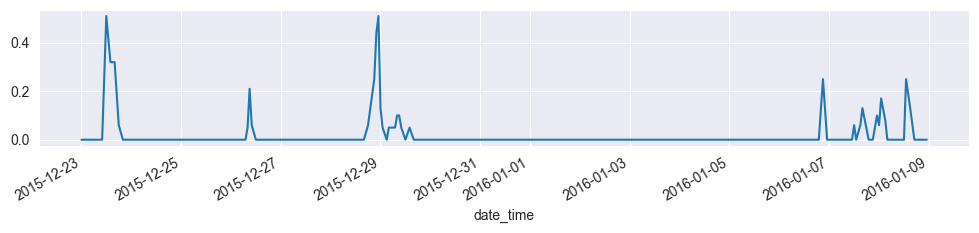

In [53]:
plot_features = df_2.loc['2015-12-23':'2016-01-08'].snow_1h
_ = plot_features.plot(figsize=(12,2))

# Cleaned Data Overview

The data overview looks better now, but still I'm concerned with the missing data block between years 2014 and 2015.

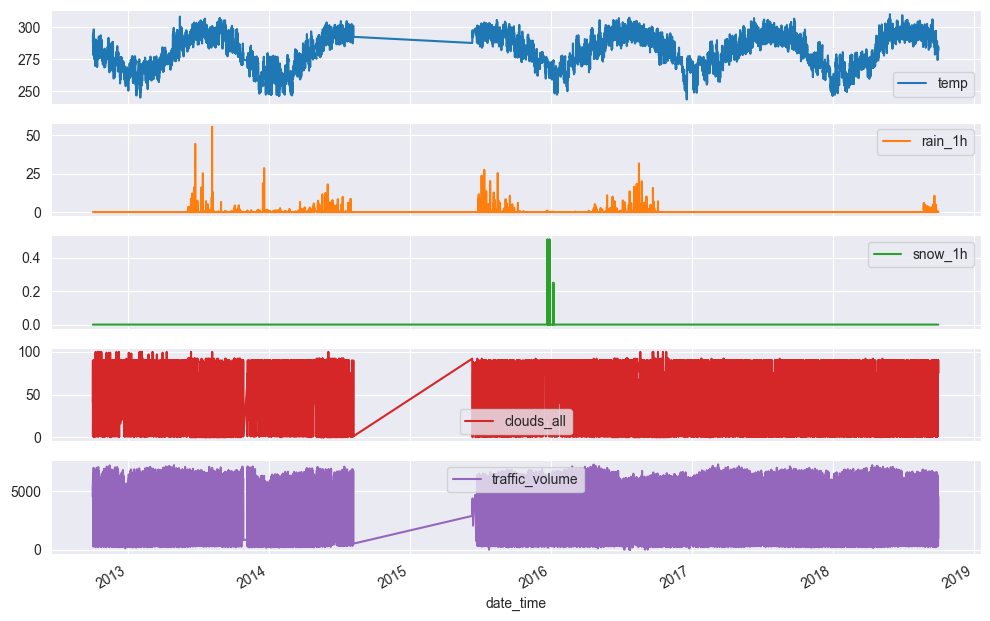

In [54]:
plot_features = df_2[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

# Feature engineering

## Weather_main and Weather description

I decided to transform the weather_main into one-hot encoded variables, and to drop the weather_description as I see that it adds kind of redundant information with weather_main.

In [55]:
df_3 = df_2.copy()
df_3.drop(columns=['weather_description'], inplace=True)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 3.9+ MB


In [56]:
df_3 = pd.get_dummies(df_3, columns=['weather_main'], prefix='weather')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               61 non-null     object 
 1   temp                  48204 non-null  float64
 2   rain_1h               48204 non-null  float64
 3   snow_1h               48204 non-null  float64
 4   clouds_all            48204 non-null  int64  
 5   traffic_volume        48204 non-null  int64  
 6   weather_Clear         48204 non-null  bool   
 7   weather_Clouds        48204 non-null  bool   
 8   weather_Drizzle       48204 non-null  bool   
 9   weather_Fog           48204 non-null  bool   
 10  weather_Haze          48204 non-null  bool   
 11  weather_Mist          48204 non-null  bool   
 12  weather_Rain          48204 non-null  bool   
 13  weather_Smoke         48204 non-null  bool   
 14  weather_Snow          48204 non-nul

In [57]:
df_3 = df_3.astype({col: 'int64' for col in df_3.columns if col.startswith('weather_')})
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               61 non-null     object 
 1   temp                  48204 non-null  float64
 2   rain_1h               48204 non-null  float64
 3   snow_1h               48204 non-null  float64
 4   clouds_all            48204 non-null  int64  
 5   traffic_volume        48204 non-null  int64  
 6   weather_Clear         48204 non-null  int64  
 7   weather_Clouds        48204 non-null  int64  
 8   weather_Drizzle       48204 non-null  int64  
 9   weather_Fog           48204 non-null  int64  
 10  weather_Haze          48204 non-null  int64  
 11  weather_Mist          48204 non-null  int64  
 12  weather_Rain          48204 non-null  int64  
 13  weather_Smoke         48204 non-null  int64  
 14  weather_Snow          48204 non-nul

## Holidays and Weekends
I think the valuable information to capture is wether the day is a holiday or a weekend. We don't need to keep track which holiday. So, we will create a new feature is_holiday and drop the old feature holiday. We don't need to keep track which weekend it is. So, we will create a new feature is_weekend.

In [58]:
df_4 = df_3.copy()
df_4['is_holiday'] = df_4['holiday'].apply(lambda x: 1 if pd.notna(x) else 0)
df_4.pop('holiday')
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  int64  
 6   weather_Clouds        48204 non-null  int64  
 7   weather_Drizzle       48204 non-null  int64  
 8   weather_Fog           48204 non-null  int64  
 9   weather_Haze          48204 non-null  int64  
 10  weather_Mist          48204 non-null  int64  
 11  weather_Rain          48204 non-null  int64  
 12  weather_Smoke         48204 non-null  int64  
 13  weather_Snow          48204 non-null  int64  
 14  weather_Squall        48204 non-nul

In [59]:
# Check sample values that are expected NOT TO BE a holiday
df_4[df_4.is_holiday == 0].head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday
date_time,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,5545,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,289.36,0.0,0.0,75,4516,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,289.58,0.0,0.0,90,4767,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,290.13,0.0,0.0,90,5026,0,1,0,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,291.14,0.0,0.0,75,4918,0,1,0,0,0,0,0,0,0,0,0,0


In [60]:
df_4[df_4.is_holiday == 1].head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,weather_Mist,weather_Rain,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday
date_time,,,,,,,,,,,,,,,,,
2012-10-08,273.08,0.0,0.0,20,455,0,1,0,0,0,0,0,0,0,0,0,1
2012-11-12,288.12,0.0,0.0,87,1000,1,0,0,0,0,0,0,0,0,0,0,1
2012-11-22,278.54,0.0,0.0,20,919,0,0,0,0,0,1,0,0,0,0,0,1
2012-12-25,264.40,0.0,0.0,90,803,0,1,0,0,0,0,0,0,0,0,0,1
2013-01-01,263.49,0.0,0.0,58,1439,0,1,0,0,0,0,0,0,0,0,0,1


In [61]:
df_4['is_weekend'] = df_4.index.day_name().map(lambda x: 1 if x in ['Saturday','Sunday'] else 0)
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  int64  
 6   weather_Clouds        48204 non-null  int64  
 7   weather_Drizzle       48204 non-null  int64  
 8   weather_Fog           48204 non-null  int64  
 9   weather_Haze          48204 non-null  int64  
 10  weather_Mist          48204 non-null  int64  
 11  weather_Rain          48204 non-null  int64  
 12  weather_Smoke         48204 non-null  int64  
 13  weather_Snow          48204 non-null  int64  
 14  weather_Squall        48204 non-nul

In [62]:
# Check sample values that are expected NOT TO BE a weekend
df_4[df_4.is_weekend == 0].index.day_name()

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday'],
      dtype='object', name='date_time', length=34501)

In [63]:
# Check sample values that are expected TO BE a weekend
df_4[df_4.is_weekend == 1].index.day_name()

Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday',
       ...
       'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday',
       'Sunday', 'Sunday', 'Sunday'],
      dtype='object', name='date_time', length=13703)

## Time
Similarly the Date Time column is very useful, but not in this form. We converting it to seconds:

In [64]:
timestamp_s = df_4.index.map(datetime.datetime.timestamp)

My assumption is that the traffic flow is seasonal and periodic based on daily and yearly periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [65]:
day = 24*60*60
year = (365.2425)*day

df_4['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_4['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_4['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_4['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_4

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Haze,...,weather_Smoke,weather_Snow,weather_Squall,weather_Thunderstorm,is_holiday,is_weekend,Day sin,Day cos,Year sin,Year cos
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,5545,0,1,0,0,0,...,0,0,0,0,0,0,0.793353,0.608761,-0.999843,0.017700
2012-10-02 10:00:00,289.36,0.0,0.0,75,4516,0,1,0,0,0,...,0,0,0,0,0,0,0.923880,0.382683,-0.999830,0.018417
2012-10-02 11:00:00,289.58,0.0,0.0,90,4767,0,1,0,0,0,...,0,0,0,0,0,0,0.991445,0.130526,-0.999817,0.019133
2012-10-02 12:00:00,290.13,0.0,0.0,90,5026,0,1,0,0,0,...,0,0,0,0,0,0,0.991445,-0.130526,-0.999803,0.019850
2012-10-02 13:00:00,291.14,0.0,0.0,75,4918,0,1,0,0,0,...,0,0,0,0,0,0,0.923880,-0.382683,-0.999788,0.020567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,0.0,75,3543,0,1,0,0,0,...,0,0,0,0,0,1,-0.382683,-0.923880,-0.999849,-0.017363
2018-09-30 20:00:00,282.76,0.0,0.0,90,2781,0,1,0,0,0,...,0,0,0,0,0,1,-0.608761,-0.793353,-0.999861,-0.016647
2018-09-30 21:00:00,282.73,0.0,0.0,90,2159,0,0,0,0,0,...,0,0,0,1,0,1,-0.793353,-0.608761,-0.999873,-0.015930


Text(0.5, 1.0, 'Time of day signal')

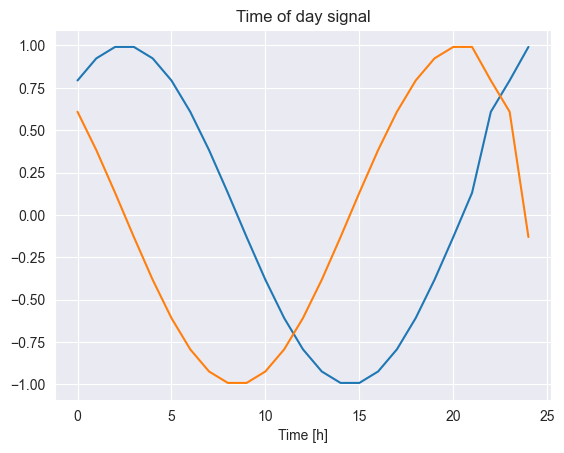

In [66]:
plt.plot(np.array(df_4['Day sin'])[:25])
plt.plot(np.array(df_4['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an fft. To check our assumptions, here is the tf.signal.rfft of the traffic_volume over time. Note the obvious peaks at frequencies near 1/year and 1/day:

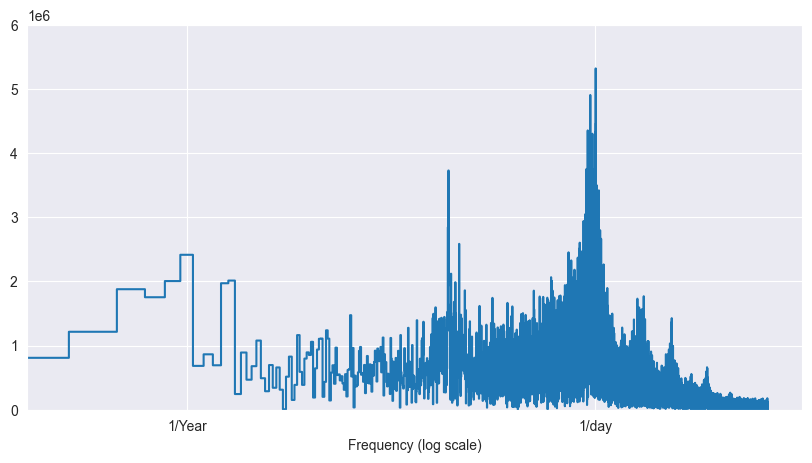

In [67]:
fft = tf.signal.rfft(df_4['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_4['traffic_volume'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(10, 5))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 6e6)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [68]:
df_4['dayofweek'] = df_4.index.dayofweek
df_4['day'] = df_4.index.day
df_4['month'] = df_4.index.month
df_4['year'] = df_4.index.year
df_4['day_hour'] = df_4.index.hour

# Reorder dataframe columns

In [69]:
df_5 = df_4.copy()

Set the traffic_volume to be the first column for ease of use later when we perform predictions

In [70]:
df_5.insert(0, 'traffic_volume', df_5.pop('traffic_volume'))
df_5.insert(1, 'Day sin', df_5.pop('Day sin'))
df_5.insert(2, 'Day cos', df_5.pop('Day cos'))
df_5.insert(3, 'Year sin', df_5.pop('Year sin'))
df_5.insert(4, 'Year cos', df_5.pop('Year cos'))
df_5.insert(5, 'temp', df_5.pop('temp'))
df_5.insert(6, 'clouds_all', df_5.pop('clouds_all'))
df_5.insert(7, 'rain_1h', df_5.pop('rain_1h'))
df_5.insert(8, 'snow_1h', df_5.pop('snow_1h'))
df_5.insert(9, 'is_weekend', df_5.pop('is_weekend'))
df_5.insert(10, 'is_holiday', df_5.pop('is_holiday'))

## Save clean data

In [71]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  int64  
 12  weather_Clouds        48204 non-null  int64  
 13  weather_Drizzle       48204 non-null  int64  
 14  weather_Fog           48204 non-nul

In [72]:
df_5.to_csv('Metro_clean_data', index=True)

# Prepare for timeseries data processing

In [76]:
df_clean = pd.read_csv('Metro_clean_data', parse_dates=['date_time'], index_col='date_time')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  int64  
 12  weather_Clouds        48204 non-null  int64  
 13  weather_Drizzle       48204 non-null  int64  
 14  weather_Fog           48204 non-nul

In [77]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
traffic_volume,48204.0,3259.818355,1986.860670,0.000000,1193.000000,3380.000000,4933.000000,7280.000000
Day sin,48204.0,-0.004710,0.705956,-0.991445,-0.793353,-0.130526,0.608761,0.991445
Day cos,48204.0,0.015027,0.708095,-0.991445,-0.608761,0.130526,0.793353,0.991445
Year sin,48204.0,0.012442,0.697615,-1.000000,-0.665775,-0.006548,0.706207,1.000000
Year cos,48204.0,-0.031671,0.715679,-1.000000,-0.743974,-0.092244,0.706867,1.000000
temp,48204.0,281.259375,12.712720,243.390000,272.160000,282.450000,291.806000,310.070000
clouds_all,48204.0,49.362231,39.015750,0.000000,1.000000,64.000000,90.000000,100.000000
rain_1h,48204.0,0.130315,1.003368,0.000000,0.000000,0.000000,0.000000,55.630000
snow_1h,48204.0,0.000222,0.008168,0.000000,0.000000,0.000000,0.000000,0.510000
is_weekend,48204.0,0.284271,0.451071,0.000000,0.000000,0.000000,1.000000,1.000000


In [78]:
df_clean.index.duplicated().sum()

np.int64(7629)

There 7629 duplicate hourly entries.
We should fix this by resampling the data to be on 1 hour basis, so that each record resembles only one hour.
Duplicate hour records will be averaged within the same hour.

## Split the data
The data will not be randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained

In [79]:
column_indices = {name: i for i, name in enumerate(df_clean.columns)}
print('Full dataset:\t', df_clean.shape[0])
num_features = df_clean.shape[1]
print('Number of features:', num_features)

Full dataset:	 48204
Number of features: 27


In [80]:
sorted(column_indices.items(), key=lambda x: x[1])

[('traffic_volume', 0),
 ('Day sin', 1),
 ('Day cos', 2),
 ('Year sin', 3),
 ('Year cos', 4),
 ('temp', 5),
 ('clouds_all', 6),
 ('rain_1h', 7),
 ('snow_1h', 8),
 ('is_weekend', 9),
 ('is_holiday', 10),
 ('weather_Clear', 11),
 ('weather_Clouds', 12),
 ('weather_Drizzle', 13),
 ('weather_Fog', 14),
 ('weather_Haze', 15),
 ('weather_Mist', 16),
 ('weather_Rain', 17),
 ('weather_Smoke', 18),
 ('weather_Snow', 19),
 ('weather_Squall', 20),
 ('weather_Thunderstorm', 21),
 ('dayofweek', 22),
 ('day', 23),
 ('month', 24),
 ('year', 25),
 ('day_hour', 26)]

The split distribution without timeseries resampling to 1 hour samples (Has duplicates)

In [81]:
train_df0 = df_clean[:-15000]
print('train_df:\t', train_df0.shape[0])
val_df0 = df_clean[-15000:-5000]
print('val_df:\t\t', val_df0.shape[0])
test_df0 = df_clean[-5000:]
print('test_df:\t', test_df0.shape[0])

train_df:	 33204
val_df:		 10000
test_df:	 5000


### After resampled and filling the duplicates

In [85]:
train_df = df_clean[:-15000].resample('h').mean().ffill()
print('train_df:\t', train_df.shape[0])
val_df = df_clean[-15000:-5000].resample('h').mean().ffill()
print('val_df:\t\t', val_df.shape[0])
test_df = df_clean[-5000:].resample('h').mean().ffill()
print('test_df:\t', test_df.shape[0])

train_df:	 40110
val_df:		 8359
test_df:	 4083


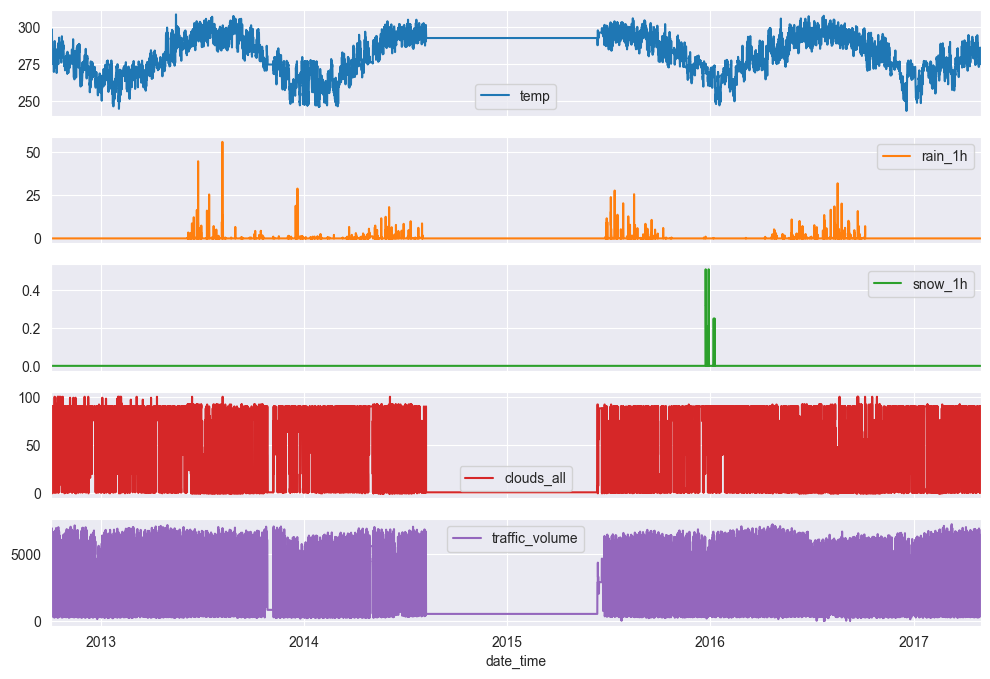

In [86]:
plot_features = train_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

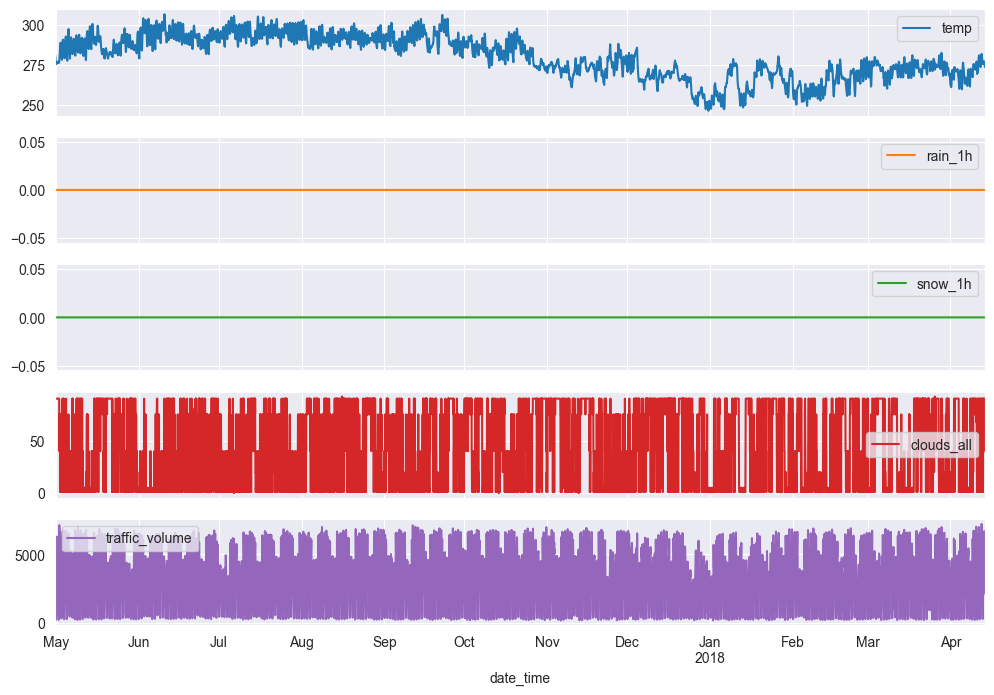

In [87]:
plot_features = val_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

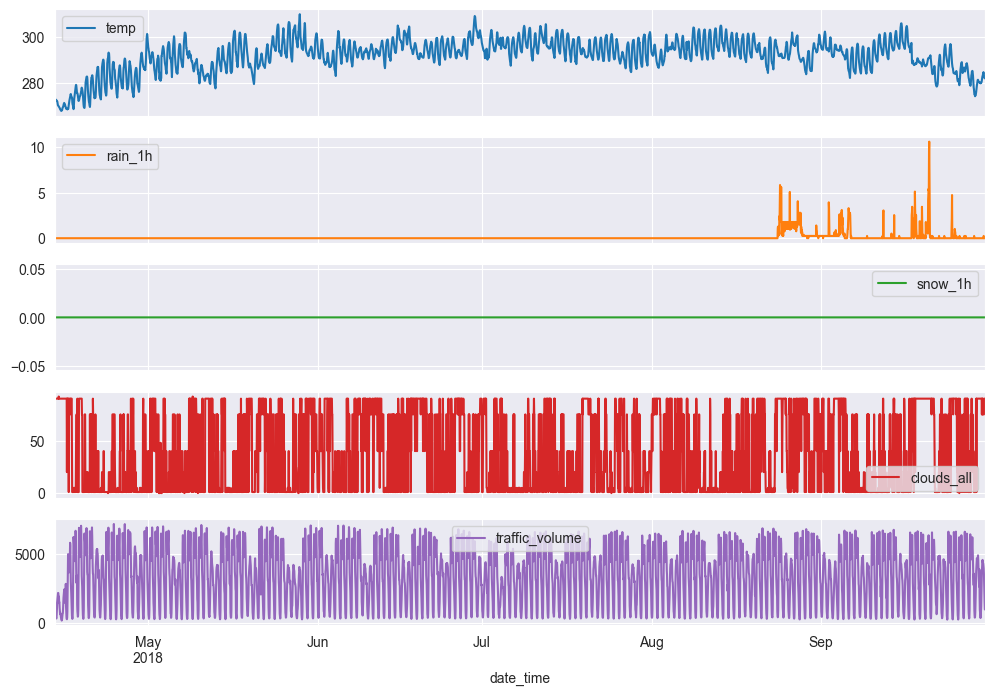

In [88]:
plot_features = test_df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12,8))

I notice that that the validation data has no rain or snow data point. Not sure how will this affect the Testing predictions.

Normalize the data
It is important to scale features before training a neural network. I tested the results using both MinMaxScaler and StandardScaler. I got better results with the MinMaxScaler, So I'll be using scikit-learn MinMaxScaler.

In [92]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
my_scaler = MinMaxScaler().fit(train_df)
my_scaler_tv = MinMaxScaler().fit(train_df[['traffic_volume']])
scaled_train_df = pd.DataFrame(my_scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
scaled_val_df = pd.DataFrame(my_scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
scaled_test_df = pd.DataFrame(my_scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

#Let's test the normalizaing and denormalizing scheme

train_df.traffic_volume.iloc[0], scaled_train_df.traffic_volume.iloc[0], \
float(my_scaler_tv.inverse_transform(scaled_train_df[['traffic_volume']])[0].item())


(np.float64(5545.0), np.float64(0.7616758241758241), 5545.0)

In [96]:
# Single value denormalization
float(my_scaler_tv.inverse_transform(np.array([[.7]]))[0, 0])

5096.0

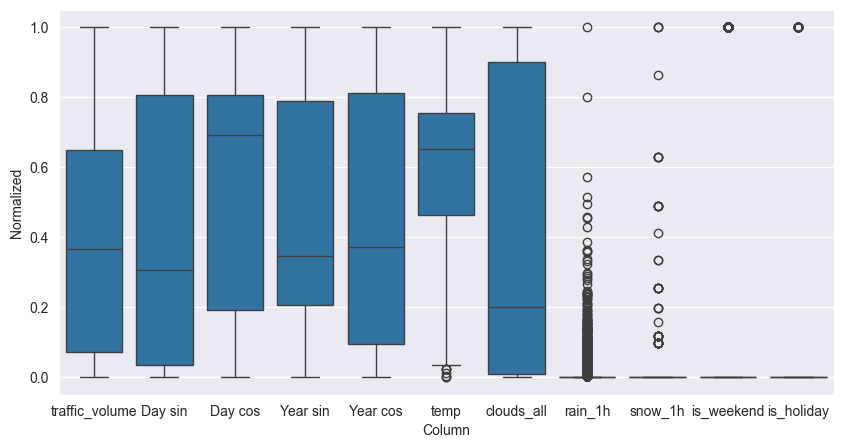

In [97]:
df_scaled = scaled_train_df.iloc[:,:11].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='Column', y='Normalized', data=df_scaled)

The data is showing rain and snow having alot of outliers. I'm unaware if this is corrupt data or if that's the actual weather in that area.

In [98]:
# Utility functions
# Special Characters for Output Formating
StartBold = "\033[1m"
EndBold = "\033[0m"

# WindowGenerator
I modified the WindowGenerator class to have all the required methods and properties consolidated from the beginging in contrast to the original design of adding the methods and properties at subsequent steps.

In [99]:
'''
[Code Provided by the tutorial]
The WindowGenerator class.
Start by creating the `WindowGenerator` class. The `__init__` method includes
all the necessary logic for the input and label indices.
It also takes the train, eval, and test dataframes as input.
These will be converted to `tf.data.Dataset`s of windows later.

This class can:

1 - Handle the indexes and offsets as shown in the diagrams above.
2 - Split windows of features into a (features, labels) pairs.
3 - Plot the content of the resulting windows.
4 - Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.
'''
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size=32,
               train_df=scaled_train_df, val_df=scaled_val_df, test_df=scaled_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.example = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    
    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.batch_size = batch_size

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size} = {self.input_width}+({self.shift-self.label_width}+{self.label_width})',
        f'Batch size: {self.batch_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices} start: [{self.label_start}]',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    '''
      Given a list consecutive inputs, the split_window method will convert
      them to a window of inputs and a window of labels.
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    '''
      The plot method that allows a simple visualization of the split window
    '''
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    # Maskar: Added this line show that we are only showing n slices
    plt.suptitle(f'Showing only {max_n} slices')
    
  def make_dataset(self, data):
    '''
      Make_dataset method will take a time series DataFrame and convert it to
      a tf.data.Dataset of (input_window, label_window) pairs using the
      preprocessing.timeseries_dataset_from_array function.
    '''
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False, # Maskar: I changed this to False
        batch_size=self.batch_size, # 32,
        )

    ds = ds.map(self.split_window)

    return ds

  # The WindowGenerator object holds training, validation and test data.
  # Add properties for accessing them as tf.data.Datasets using the above make_dataset method.
  # Also add a standard example batch for easy access and plotting:
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  @example.setter
  def example(self, var):
    self._example = var

## Plotting Function

In [100]:
def plot_train_validation(history, validation_data, metric='mean_absolute_error'):
    '''
    Function to plot the training and validation accuracy progress with epochs for a single model
    '''
    plt.plot(history.history[metric], label='train')  # For TF2
    plt.plot(history.history['val_'+metric], label='valid.')  # For TF2
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xticks(range(1,len(history.history['loss'])+1,2))
    #plt.ylim([0.5, 1])
    plt.title(f'{len(history.history[metric])} epochs')
    plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.show()

    # Evaluate the learned model with validation set
    print(f'\n\n{StartBold}Validation Scores:{EndBold}\n')
    _ = history.model.evaluate(validation_data, verbose=2)

In [101]:
class TrainingPlot(Callback):
    '''
      A keras callback helper function to plot
      the taining/validation plot after each epoch
    '''
    def __init__(self, loss_metric='mean_absolute_error'):
      super().__init__()
      self.loss_metric = loss_metric

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get(self.loss_metric)
        val_loss = logs.get('val_'+self.loss_metric)
                
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.val_losses.append(val_loss)
        
        # Plots every n-th epoch
        if epoch > 0 and epoch%1==0:
            
            # Clear the previous plot
            IPython.display.clear_output(wait=True)
            #clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            #plt.style.use("seaborn")            
            #plt.figure(figsize=(10,3))
            plt.xlabel('Epoch')
            plt.ylabel(self.loss_metric)
            plt.plot(N, self.losses, label='train')
            plt.plot(N, self.val_losses, label='valid.')
            plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
            #val_denorm = float(my_scaler_tv.inverse_transform(np.array([[val_loss]])))
            val_denorm = my_scaler_tv.inverse_transform(np.array([[val_loss]]))[0, 0] # New Fix

            plt.title(f'Last validation value = {val_denorm:.2f}')
            plt.legend(loc='upper right')          
            plt.show()

In [107]:
def compile_and_fit(model, window, patience=5, max_epochs=15,
                    model_label='model', log_dict=None):
    plot_metrics = TrainingPlot()

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.001, patience=patience, mode='min', verbose=1 )

    #mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True )

    model.compile( optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()] )

    history = model.fit( window.train, epochs=max_epochs, validation_data=window.val, callbacks=[plot_metrics, early_stopping, rlr] )
  
    if log_dict:
        log_dict['my_models'][model_label] = model

        IPython.display.clear_output()

        print(f'\n\n{StartBold}Training vs. Validation:{EndBold}\n')
        plot_train_validation(history, window.val)

        log_dict['multi_val_performance'][model_label] = model.evaluate(window.val, verbose=0)
        log_dict['multi_performance'][model_label] = model.evaluate(window.train, verbose=0)


    predictions = model.predict(window.val)
    evaluate_predictions(val_df.traffic_volume, predictions)  
    return history

In [113]:
import keras
print("Keras Version:", keras.__version__)

Keras Version: 3.9.0


In [114]:
from tensorflow.keras.metrics import MeanAbsoluteError

In [119]:
def evaluate_predictions(y_true, y_pred, plot_start_index=-500):
    print(f'\n\n{StartBold}Predictions Evaluation:{EndBold}\n')
    y_p = np.asarray(my_scaler_tv.inverse_transform(y_pred.reshape(-1,1))).ravel()
    n_predictions = len(y_p)
    y = np.asarray(y_true[-n_predictions:]).ravel()
    print('Predictions:', n_predictions)
    
    #The new fix code below
    mae_loss = MeanAbsoluteError()
    mae = float(mae_loss(y, y_p).numpy())
    
    mae_scaled = my_scaler_tv.transform(np.array([[mae]]))[0, 0] # New Fix

    print(f'MAE: {mae:.2f} ({mae_scaled:.4f})')

    plt.subplots(figsize=(15,2))
    plt.plot(y[plot_start_index:], marker='.', label='true')
    plt.plot(y_p[plot_start_index:], marker='.', label='predicted')
    plt.legend()
    plt.show()

# Models
The required window

Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

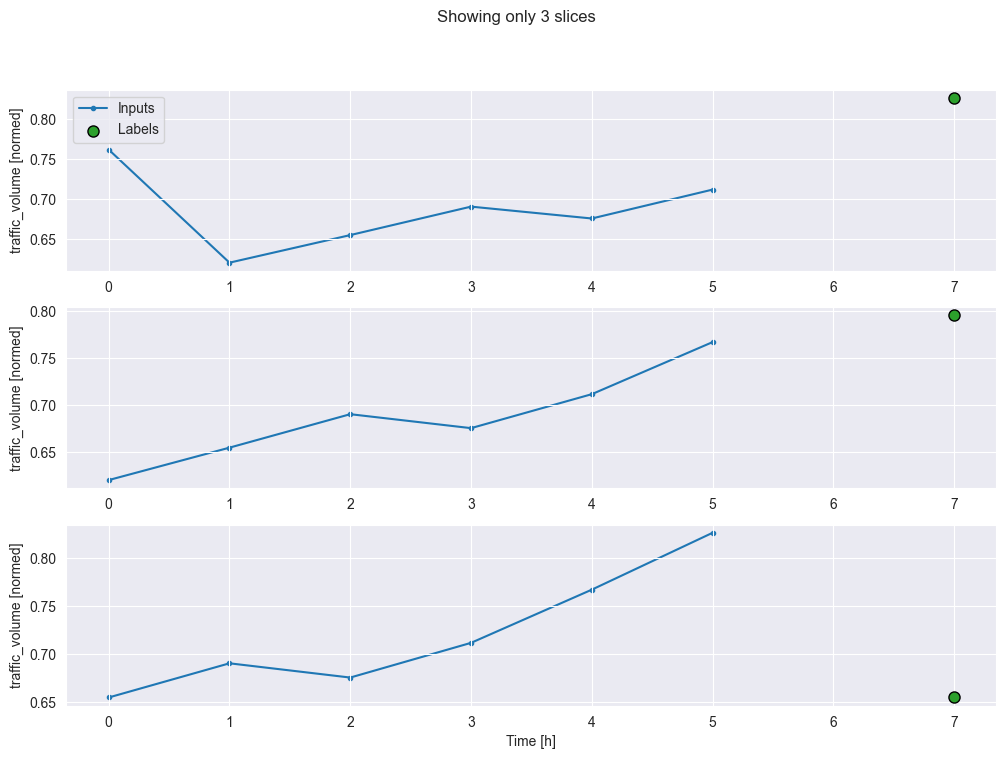

In [120]:
INPUT_WIDTH = 6
OUT_STEPS = 1
SHIFT = 2
base_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )

base_window.plot()
base_window

### Baseline Models

In [121]:
multi_val_performance = {}
multi_performance = {}
my_models = {}

my_log = {
    'multi_val_performance':multi_val_performance,
    'multi_performance':multi_performance,
    'my_models':my_models
    }

I set all the models to converge into a single output value, which is the traffic volume at the 8th day based on 6 days input of the full features.

Dense
Using only layers.Dense between the input and output gives a decent linear model.



Training vs. Validation:


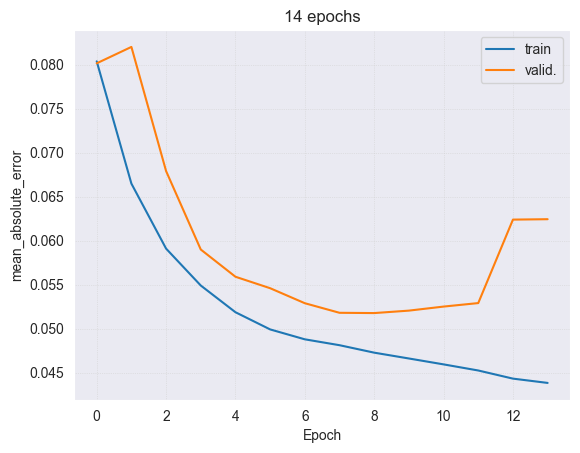



Validation Scores:
261/261 - 0s - 2ms/step - loss: 0.0053 - mean_absolute_error: 0.0518
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predictions Evaluation:

Predictions: 8352
MAE: 376.81 (0.0518)


C:\Projects\Personel_Project\Traffic_Congestion_Prediction\pythonProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


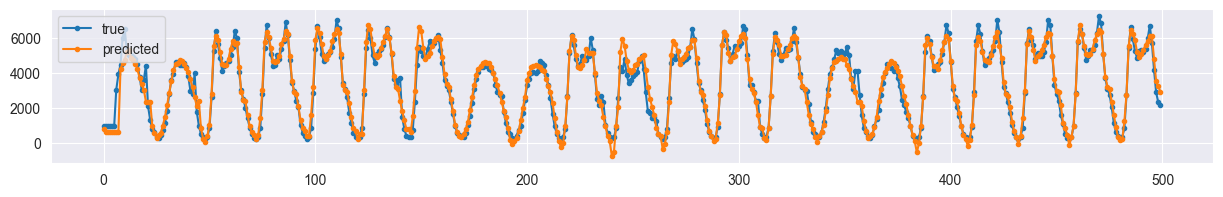

CPU times: total: 2min 52s
Wall time: 1min 5s


In [122]:
%%time
model_label = 'Dense'
current_window = base_window

dense_model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(dense_model, current_window,
                          model_label=model_label, log_dict=my_log)

## CNN
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:



Training vs. Validation:


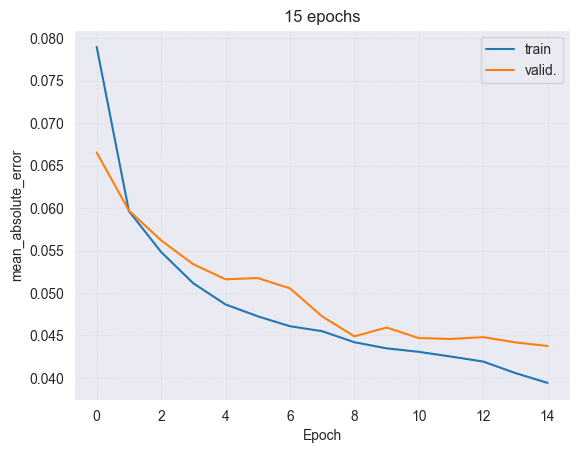



Validation Scores:
261/261 - 1s - 2ms/step - loss: 0.0043 - mean_absolute_error: 0.0438
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Predictions Evaluation:

Predictions: 8352
MAE: 318.51 (0.0438)


C:\Projects\Personel_Project\Traffic_Congestion_Prediction\pythonProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


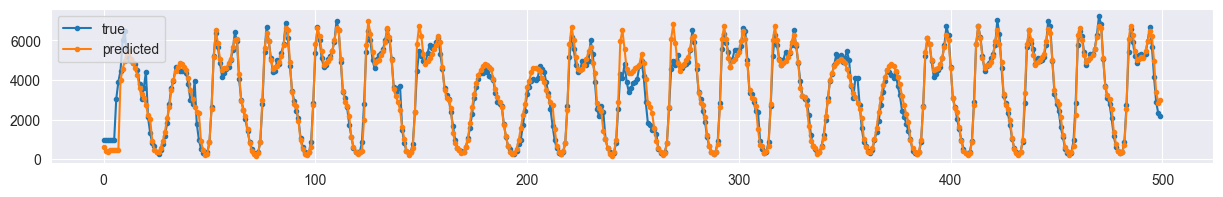

CPU times: total: 11min 19s
Wall time: 2min 2s


In [123]:
%%time
model_label = 'Conv'
current_window = base_window

CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(conv_model, current_window,
                          model_label=model_label, log_dict=my_log)

## RNN



Training vs. Validation:


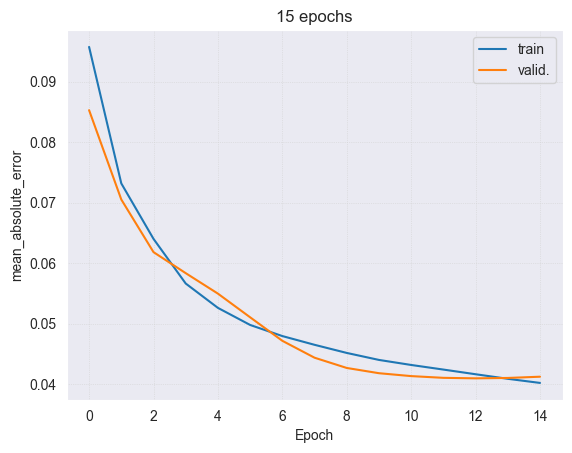



Validation Scores:
261/261 - 1s - 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0410
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Predictions Evaluation:

Predictions: 8352
MAE: 298.36 (0.0410)


C:\Projects\Personel_Project\Traffic_Congestion_Prediction\pythonProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


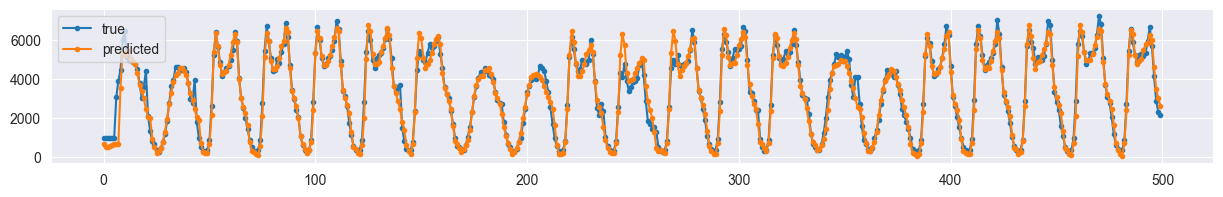

CPU times: total: 4min 4s
Wall time: 1min 23s


In [124]:
%%time
model_label = 'LSTM'
current_window = base_window

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    Dense(OUT_STEPS)
])

history = compile_and_fit(lstm_model, current_window,
                          model_label=model_label, log_dict=my_log)

## My Models
I created another Window Gen to experiment with the batch size in my models

In [125]:
my_window1 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )
print("my_window1", my_window1)

# I created another WindowGen to experiment with the batch size in my models
my_window2 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=64
                               )
print("my_window2", my_window2)

my_window1 Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']
my_window2 Total window size: 8 = 6+(1+1)
Batch size: 64
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']


## Model 1



Training vs. Validation:


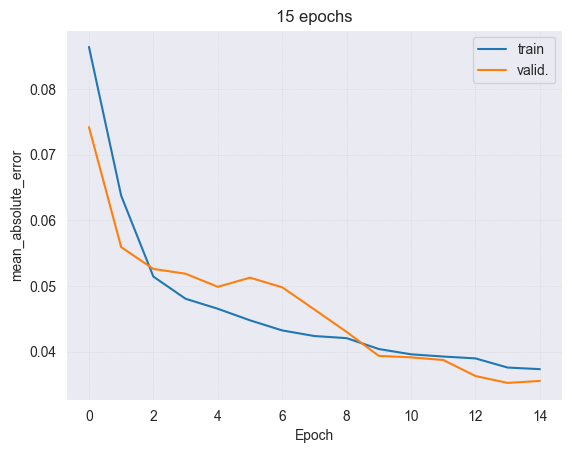



Validation Scores:
261/261 - 4s - 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0352
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


Predictions Evaluation:

Predictions: 8352
MAE: 256.55 (0.0352)


C:\Projects\Personel_Project\Traffic_Congestion_Prediction\pythonProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


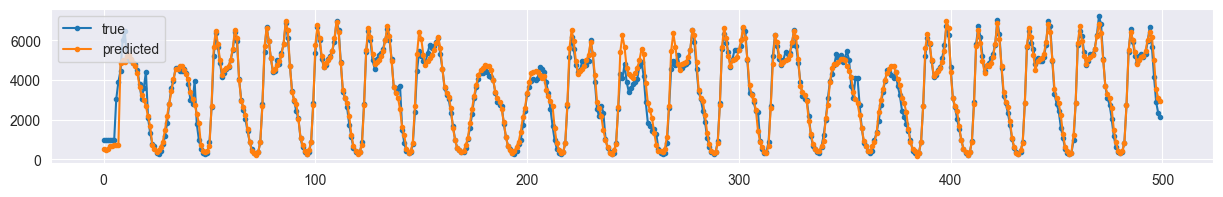

CPU times: total: 2h 50min 18s
Wall time: 20min 13s


In [126]:
%%time
model_label = 'MyLSTM_1'
current_window = my_window1

my_lstm_model = tf.keras.Sequential([
    LSTM(512, return_sequences=True),
    LSTM(512, return_sequences=False),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [127]:
final1_predictions = my_models['MyLSTM_1'].predict(my_window1.test)
final1_predictions

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


array([[0.07289909],
       [0.11243869],
       [0.1697043 ],
       ...,
       [0.3835575 ],
       [0.3101947 ],
       [0.16407257]], dtype=float32)

In [128]:
actual1_labels = []
for inputs, labels in my_window1.test:
    actual1_labels.append(labels.numpy())

# Convert list of arrays into a single numpy array
actual1_labels = np.concatenate(actual1_labels, axis=0)

In [129]:
print("Predictions shape:", final1_predictions.shape)
print("Actual labels shape:", actual1_labels.shape)

Predictions shape: (4076, 1)
Actual labels shape: (4076, 1, 1)


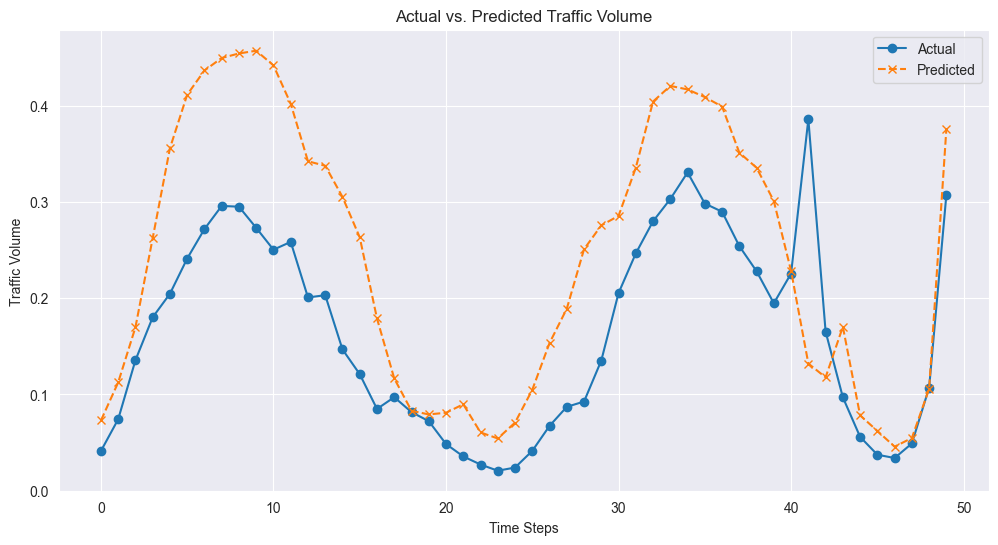

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual1_labels[:50, 0], label="Actual", marker="o")
plt.plot(final1_predictions[:50, 0], label="Predicted", marker="x", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")

plt.savefig('ActualVsPredicted.png')

plt.show()

In [131]:
my_lstm_model.save('MyLSTM_1.keras')

In [132]:
my_lstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 6, 512)         │     1,105,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,192,837 (42.70 MB)

 Trainable params: 3,730,945 (14.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,461,892 (28.46 MB)

# Model 2 



Training vs. Validation:


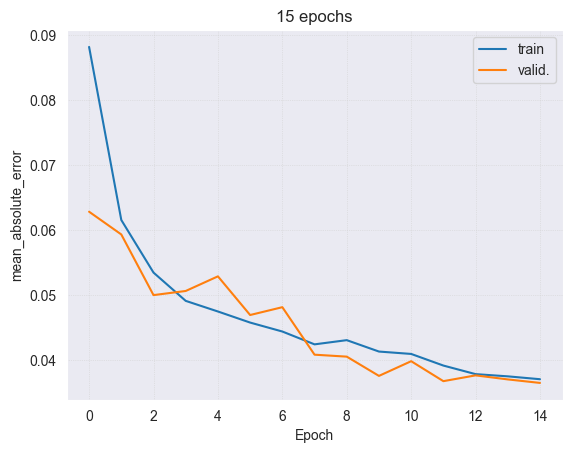



Validation Scores:
261/261 - 6s - 23ms/step - loss: 0.0031 - mean_absolute_error: 0.0365
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step


Predictions Evaluation:
Predictions: 8352
MAE: 265.73 (0.0365)


C:\Projects\Personel_Project\Traffic_Congestion_Prediction\pythonProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


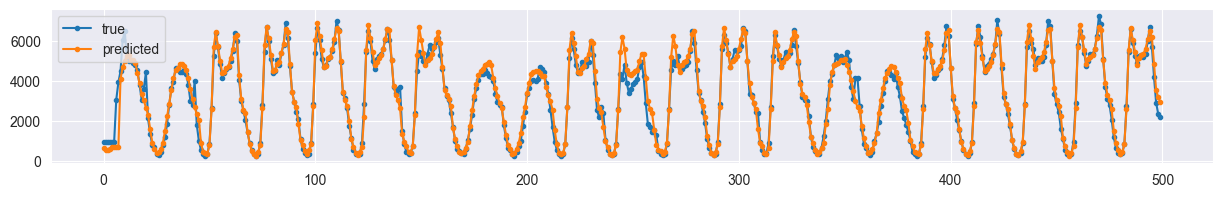

CPU times: total: 7h 33min 2s
Wall time: 42min 33s


In [133]:
%%time
model_label = 'MyLSTM_2'
current_window = my_window1

forward_layer = LSTM(512, return_sequences=True)
backward_layer = LSTM(512, return_sequences=True, go_backwards=True)
 
my_lstm_model_2 = tf.keras.Sequential([
    Bidirectional(forward_layer, backward_layer=backward_layer),
    Bidirectional(LSTM(512, return_sequences=False, stateful=False)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(my_lstm_model_2, current_window,
                          model_label=model_label, log_dict=my_log,
                          )

In [134]:
my_lstm_model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 6, 1024)        │     2,211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1024)           │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,886,085 (106.38 MB)

 Trainable params: 9,295,361 (35.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,590,724 (70.92 MB)

In [135]:
my_lstm_model_2.save('MyLSTM_2.keras')

In [137]:
final2_predictions = my_models['MyLSTM_2'].predict(my_window1.test)
final2_predictions

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


array([[0.06579001],
       [0.09365201],
       [0.13561797],
       ...,
       [0.40113533],
       [0.31549925],
       [0.19302796]], dtype=float32)

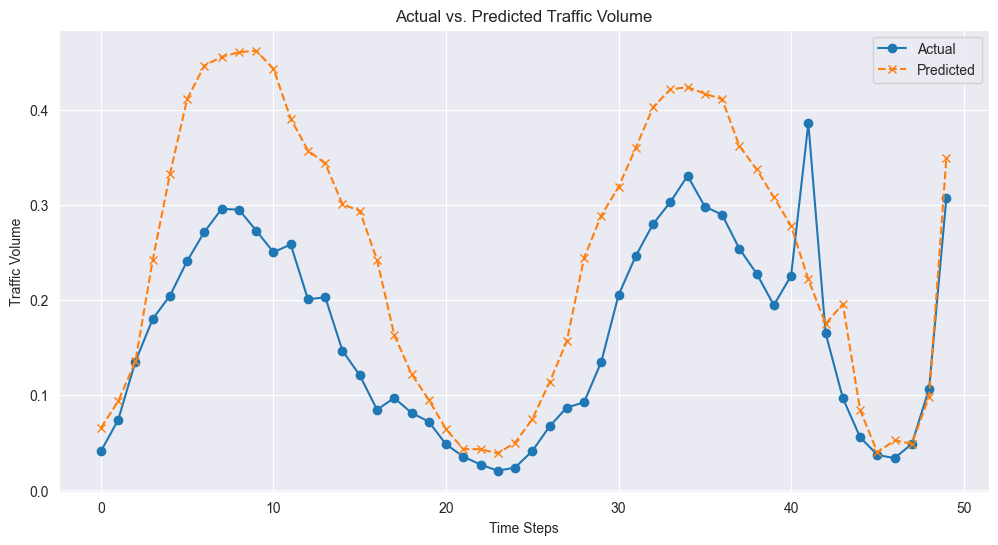

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual1_labels[:50, 0], label="Actual", marker="o")
plt.plot(final2_predictions[:50, 0], label="Predicted", marker="x", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.title("Actual vs. Predicted Traffic Volume")

plt.savefig('ActualVsPredicted.png')

plt.show()

## Comparing all the models

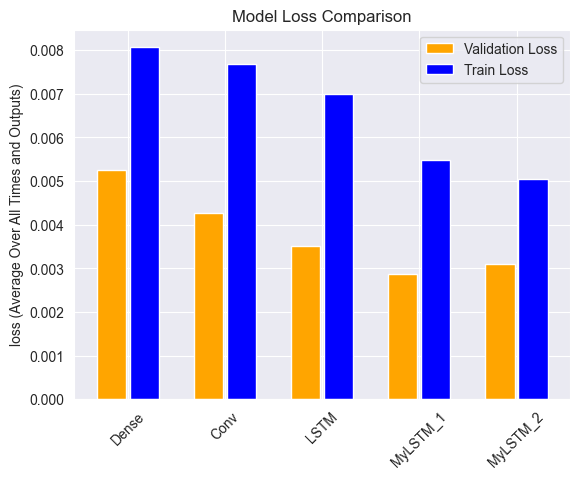

In [142]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'loss'  # Change from 'mean_absolute_error' to 'loss'
metric_index = my_lstm_model.metrics_names.index(metric_name)

val_loss = [v[metric_index] for v in multi_val_performance.values()]
train_loss = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_loss, width, label='Validation Loss', color='orange')
plt.bar(x + 0.17, train_loss, width, label='Train Loss', color='blue')

plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'{metric_name} (Average Over All Times and Outputs)')
plt.title('Model Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


#### work on below code

In [140]:
metric_names = my_lstm_model.metrics_names

# Check if 'mae' or 'mean_absolute_error' exists
if 'mean_absolute_error' in metric_names:
    metric_name = 'mean_absolute_error'
    print('ifff')
elif 'mae' in metric_names:
    metric_name = 'mae'
    print('elif...')
else:
    raise ValueError("MAE metric not found in model metrics!")

ValueError: MAE metric not found in model metrics!

In [141]:
print("Available Metrics:", my_lstm_model.metrics_names)

Available Metrics: ['loss', 'compile_metrics']
